# ABS Quarterly Estimated Resident Population 3101

## Python set-up

In [1]:
# system imports
import sys

# local imports
import decompose
import matplotlib.pyplot as plt

# analytic imports
import pandas as pd
from abs_data_capture import (
    find_id,
    get_ABS_meta_and_data,
    get_fs_constants,
    get_meta_constants,
    get_plot_constants,
)
from henderson import hma
from plotting import (
    abbreviate,
    calc_growth,
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_covid_recovery,
    plot_growth_finalise,
    recalibrate,
    seas_trend_plot,
    set_chart_dir,
    state_abbr,
    state_colors,
)
from statsmodels.tsa.seasonal import seasonal_decompose

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# Display charts in this notebook
SHOW = True

## Get data from ABS

In [2]:
catalogue_id = "3101"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

erp_dict = get_ABS_meta_and_data(catalogue_id)
if erp_dict is None:
    sys.exit(-1)

erp_meta = erp_dict[META_DATA]
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()
RECENT, plot_times, plot_tags = get_plot_constants(erp_meta)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


In [3]:
erp_meta["Table Description"].unique()

array(["Population Change, Summary - Australia ('000)",
       'Interstate Arrivals, States and Territories (Persons)',
       'Interstate Departures, States and Territories (Persons)',
       'Population Change, Components - States and Territories (Number)',
       'Estimated Resident Population, States and Territories (Number)',
       'Estimated Resident Population By Single Year Of Age, New South Wales',
       'Estimated Resident Population By Single Year Of Age, Victoria',
       'Estimated Resident Population By Single Year Of Age, Queensland',
       'Estimated Resident Population By Single Year Of Age, South Australia',
       'Estimated Resident Population By Single Year Of Age, Western Australia',
       'Estimated Resident Population By Single Year Of Age, Tasmania',
       'Estimated Resident Population By Single Year Of Age, Northern Territory',
       'Estimated Resident Population By Single Year Of Age, Australian Capital Territory',
       'Estimated Resident Populatio

## Plotting

In [4]:
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")

### Key charts

In [5]:
def key_charts():
    table = "1"
    series_type = "Original"
    data = erp_dict[table]

    key_charts = [
        "Births",
        "Deaths",
        "Natural Increase",  # births - deaths
        "Overseas Arrivals",
        "Overseas Departures",
        "Net Overseas Migration",
    ]
    starts = RECENT  # plot_times
    for chart in key_charts:
        selector = {
            table: table_col,
            series_type: type_col,
            chart: did_col,
        }
        id, units = find_id(erp_meta, selector, verbose=False)
        series = data[id]
        series.name = chart
        series, units = recalibrate(series, units)

        # raw data plot
        common_plot_settings = {
            "title": chart,
            "y0": True,
            "ylabel": f"{units} / Quarter",
            "rfooter": f"{source} {table}",
            "show": SHOW,
        }
        line_plot(
            series,
            lfooter=f"Australia. {series_type} series. ",
            **common_plot_settings,
        )

        # in-house seasonal decomp
        common_plot_settings["starts"] = starts
        decomposed = decompose.decompose(
            series,
            constantSeasonal=True,
            # seasonalSmoother=decompose.s3x9,
        )
        seas_trend_plot(
            decomposed[["Seasonally Adjusted", "Trend"]],
            tags="sa-Mark",
            lfooter="Australia. Seasonally adjusted using in-house methods. ",
            **common_plot_settings,
        )

        # python's seasonal decomp
        if series.gt(0).all():
            result = seasonal_decompose(series, model="multiplicable", period=4)
            df = pd.DataFrame(
                [series / result.seasonal, result.trend],
                index=["Seasonally Adjusted", "Trend"],
            ).T
            seas_trend_plot(
                df,
                tags="sa-python",
                lfooter="Australia. Seasonally adjusted using Python's "
                "seasonal_decompose() from statsmodels.tsa.seasonal. ",
                **common_plot_settings,
            )

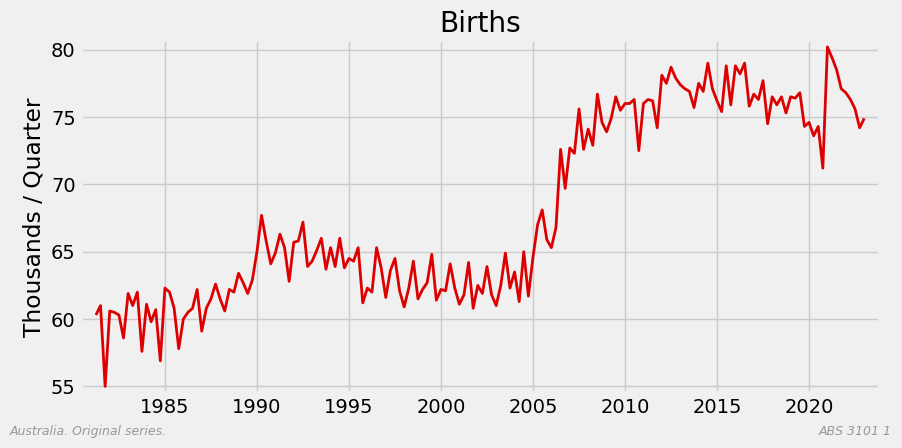

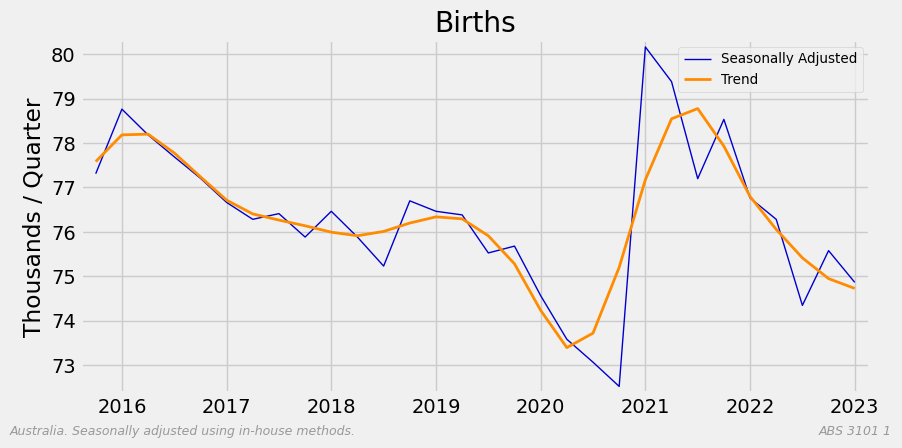

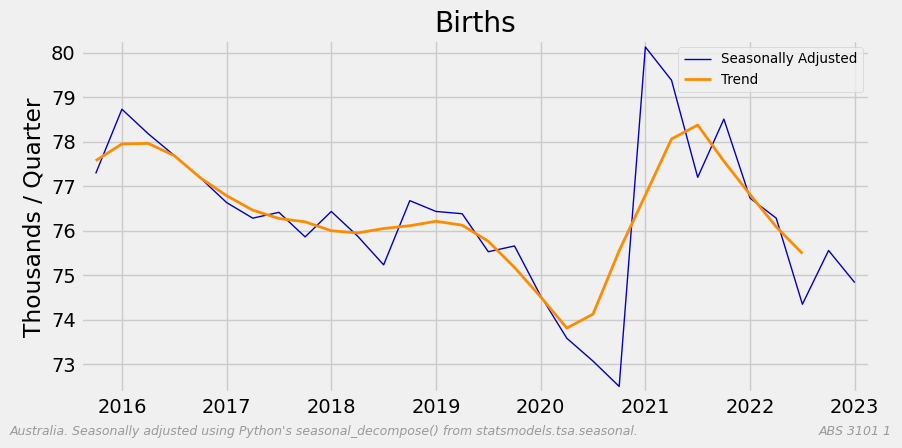

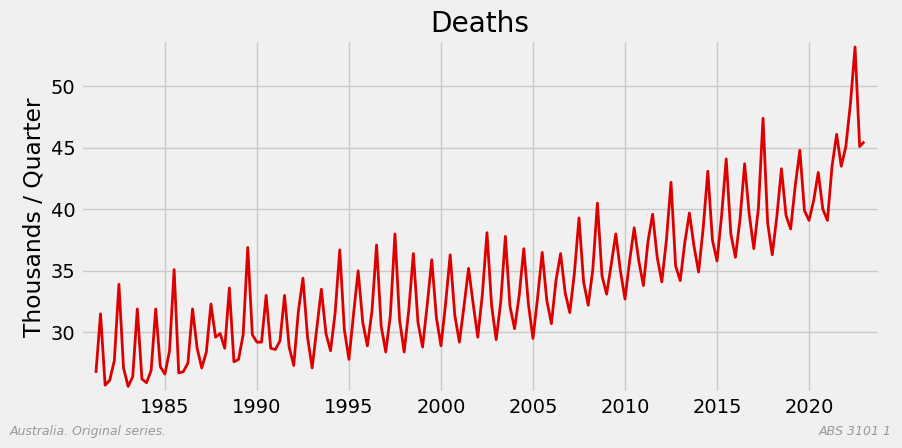

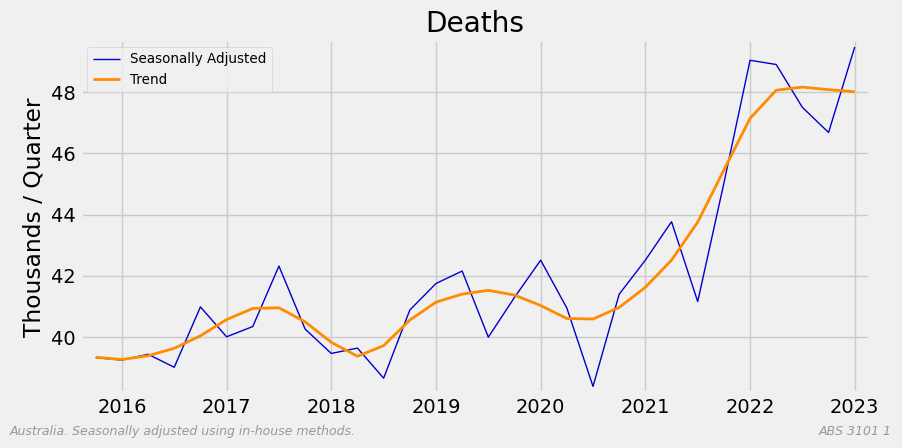

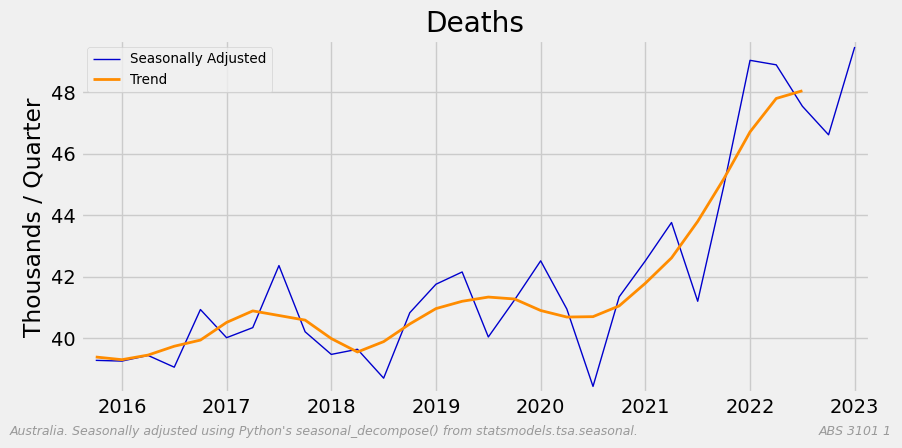

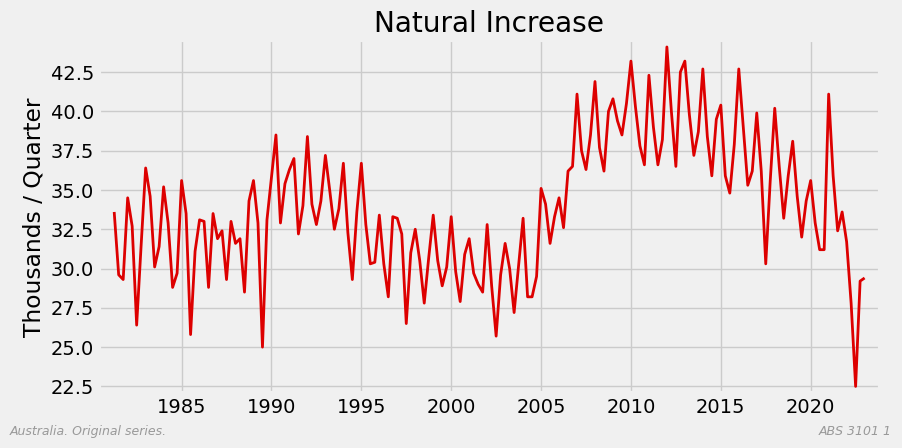

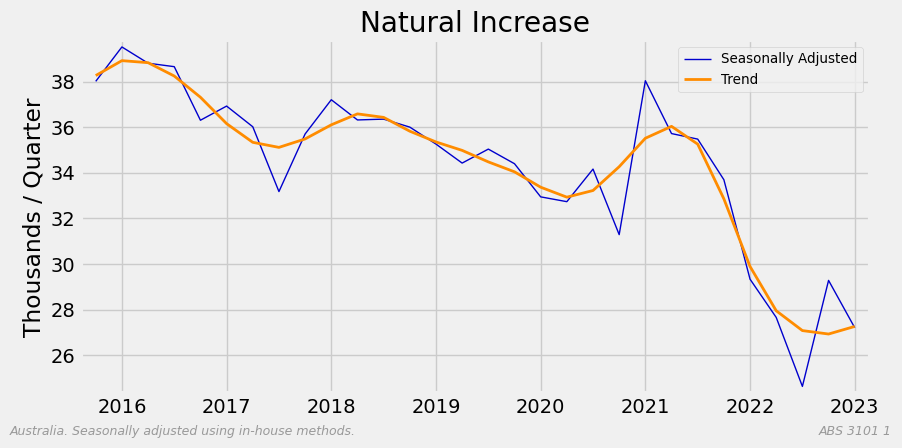

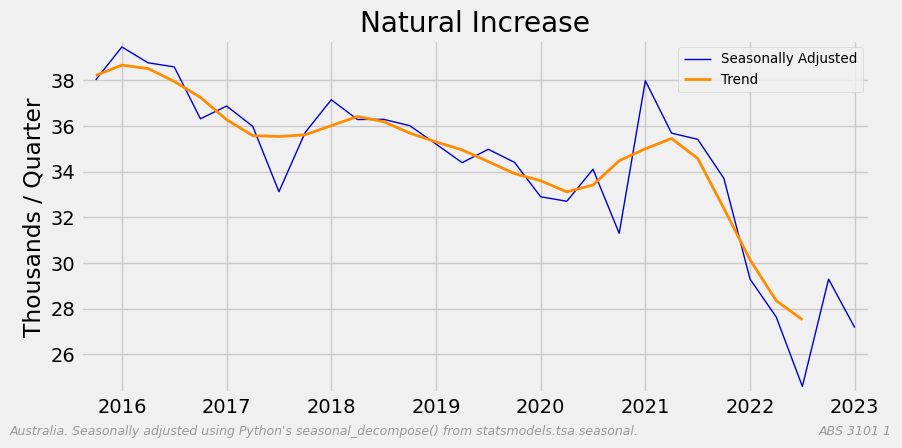

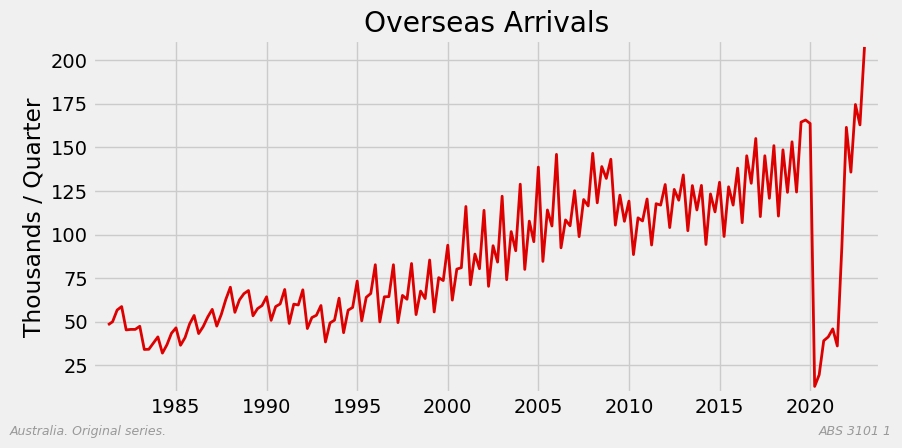

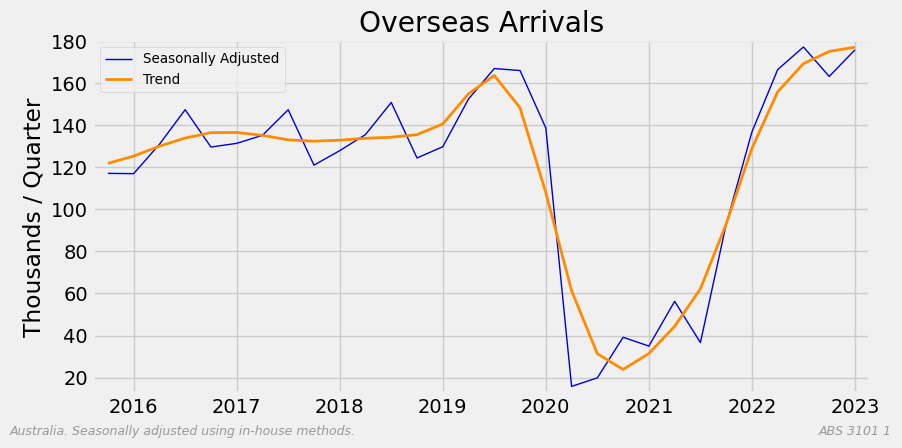

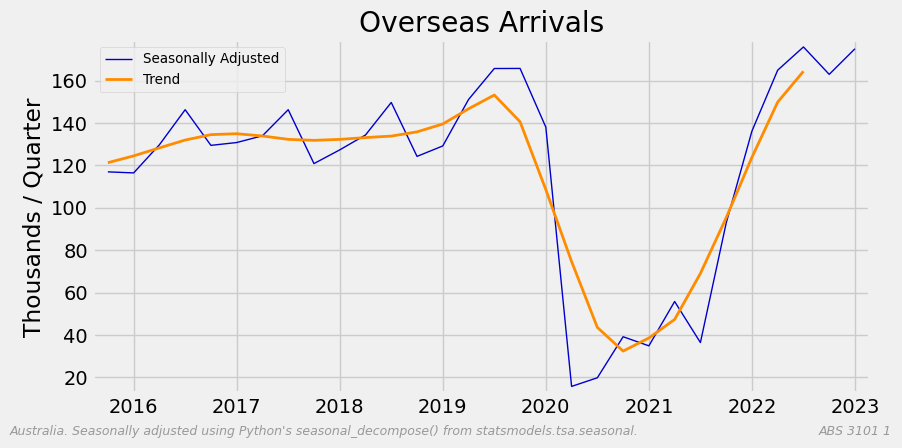

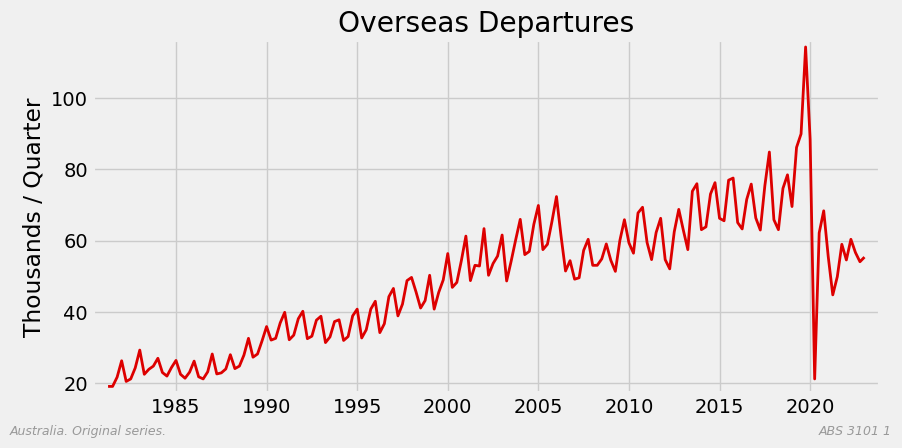

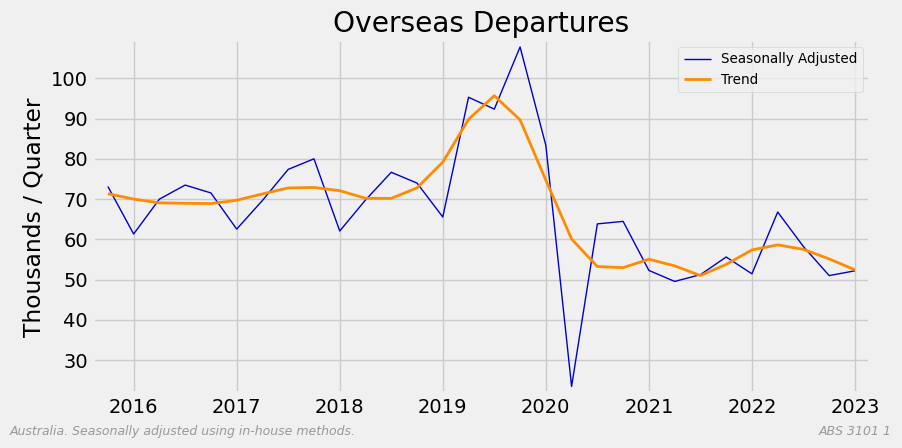

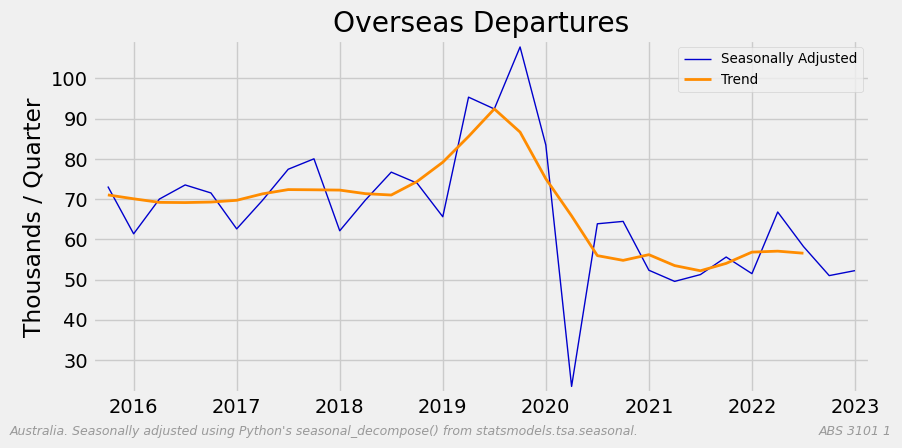

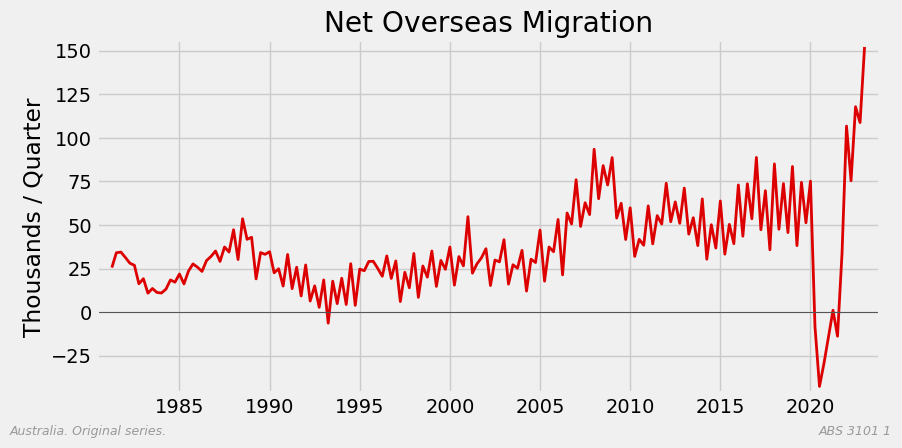

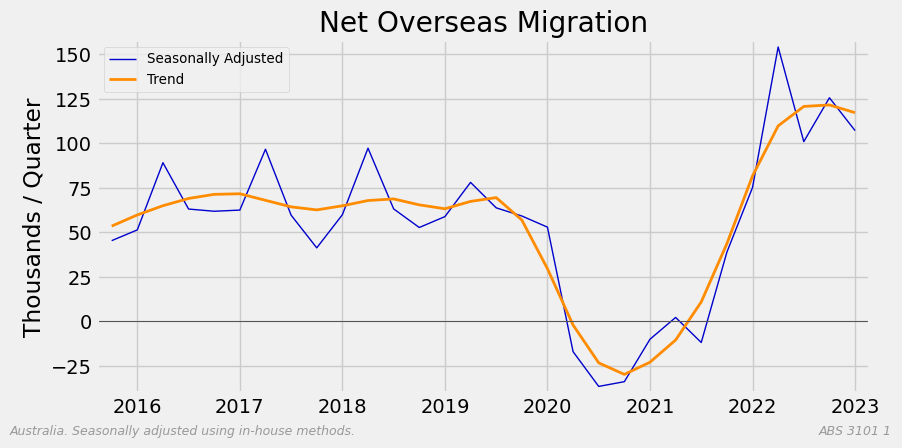

In [6]:
key_charts()

### Age related

#### set-up parameters

In [7]:
tables = tuple(str(i) for i in range(51, 60))
groups = ("Female", "Male", "Persons")  # persons should be last

state_colors["Australia"] = "grey"
linestyle = {
    "style": [
        "-",
        "-.",
        "--",
        ":",
    ]
    * 3  # repeat enough to cover all series
}

#### Utility functions

In [8]:
def get_age_data(table: str, group: str) -> tuple[str, pd.DataFrame]:
    # identify the relevant data
    relevant = erp_meta[
        (erp_meta[table_col] == table) & erp_meta[did_col].str.contains(group)
    ]

    # identify state
    state = relevant["Table Description"].iloc[0].split(",")[-1].strip()
    if state in state_abbr:
        state = state_abbr[state]

    # get raw data and associated labels
    columns = relevant[id_col]
    data = erp_dict[table][columns]
    labels = (
        relevant[did_col]
        .str.rsplit(";", n=2)
        .str[-2]
        .str.replace("100 and over", "100")
        .astype(int)
    )
    data.columns = labels
    return state, data

In [9]:
def calculate_medians(data: pd.DataFrame) -> pd.Series:
    HALF = 0.5

    # calculate whole-year medians
    row_total = data.sum(axis=1)
    cumulative = data.div(row_total, axis=0).cumsum(axis=1)
    whole_median_age = cumulative.gt(HALF).idxmax(axis=1) - 1

    # calculate (imputed) fractional-year medians.
    low = pd.Series(
        {
            x: cumulative.loc[x, y]
            for x, y in zip(whole_median_age.index, whole_median_age.values)
        }
    )
    high = pd.Series(
        {
            x: cumulative.loc[x, y + 1]
            for x, y in zip(whole_median_age.index, whole_median_age.values)
        }
    )
    fractional_age = (HALF - low) / (high - low)
    fractional_median_age = whole_median_age + fractional_age
    return fractional_median_age

#### Age profiles

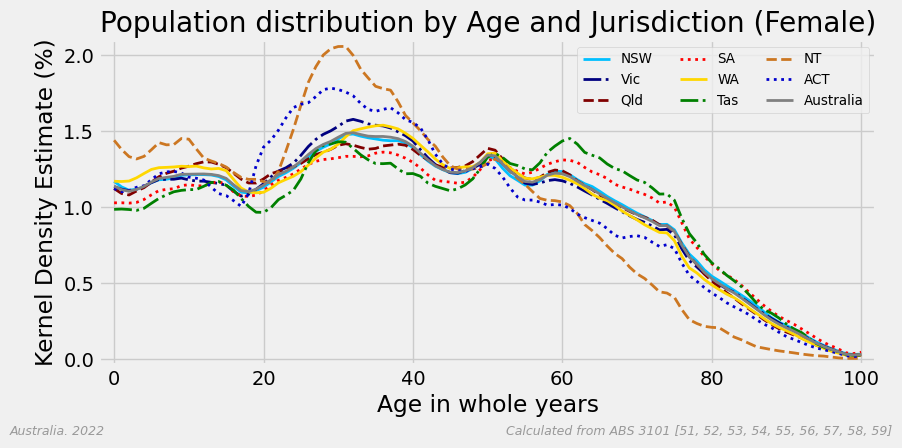

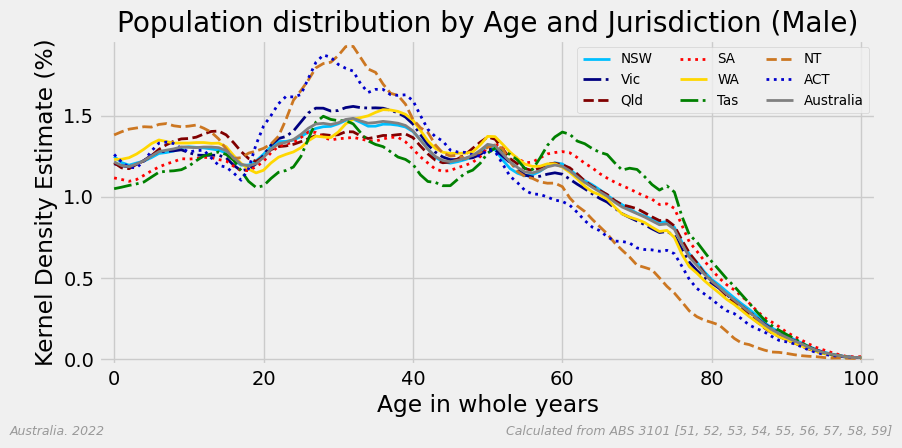

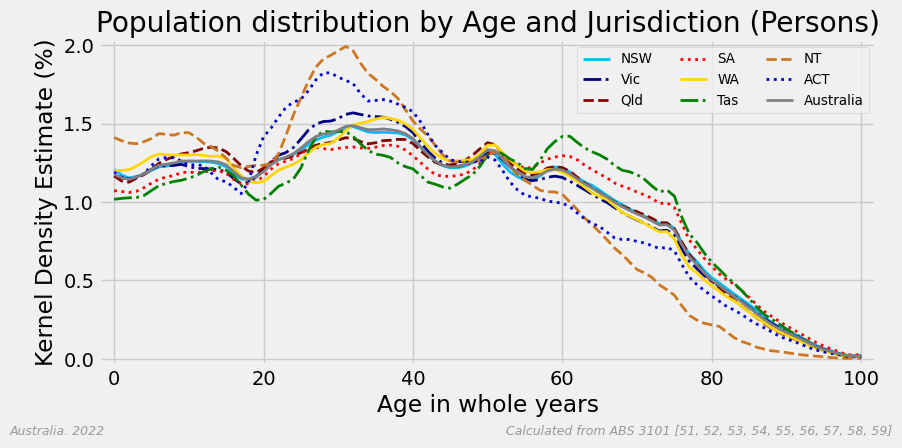

In [10]:
HMA_SMOOTHER = 5

for group in groups:
    state_compositions = {}
    
    for table in tables:
        # data capture
        state, data = get_age_data(table, group)
        period = data.index[-1]
        data = data.iloc[-1]

        # limited smoothing and store
        data = hma(data / data.sum() * 100, HMA_SMOOTHER)
        state_compositions[state] = data

    # plot age profile ...
    state_compositions = pd.DataFrame(state_compositions)
    colors = [state_colors[x] for x in state_compositions.columns]
    ax = state_compositions.plot(
        lw=2,
        color=colors,
        **linestyle,
    )
    finalise_plot(
        axes=ax,
        title=f"Population distribution by Age and Jurisdiction ({group})",
        ylabel="Kernel Density Estimate (%)",
        xlabel="Age in whole years",
        legend={"loc": "best", "fontsize": "x-small", "ncols": 3},
        tag=group,
        lfooter=f"Australia. {period}",
        rfooter=f"Calculated from {source} {[int(i) for i in tables]}",
        show=SHOW,
    )

#### Median Age by state

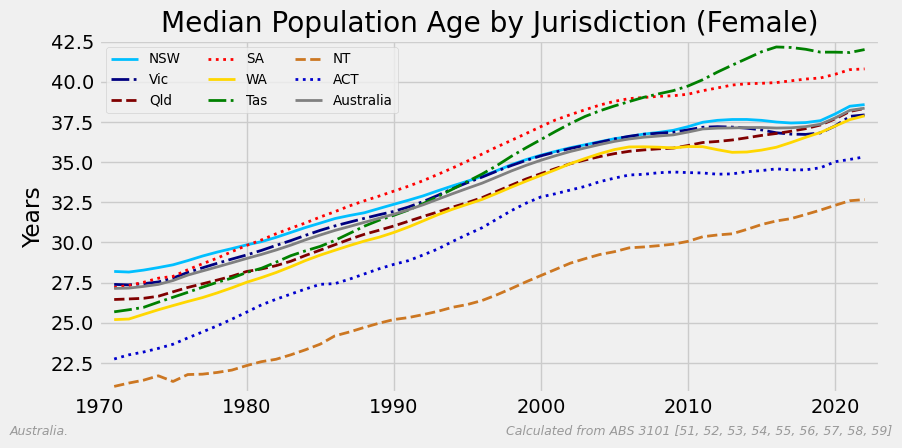

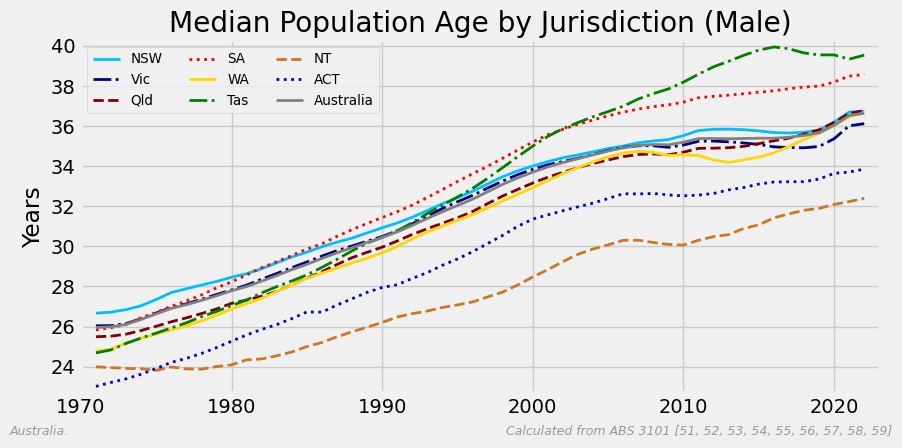

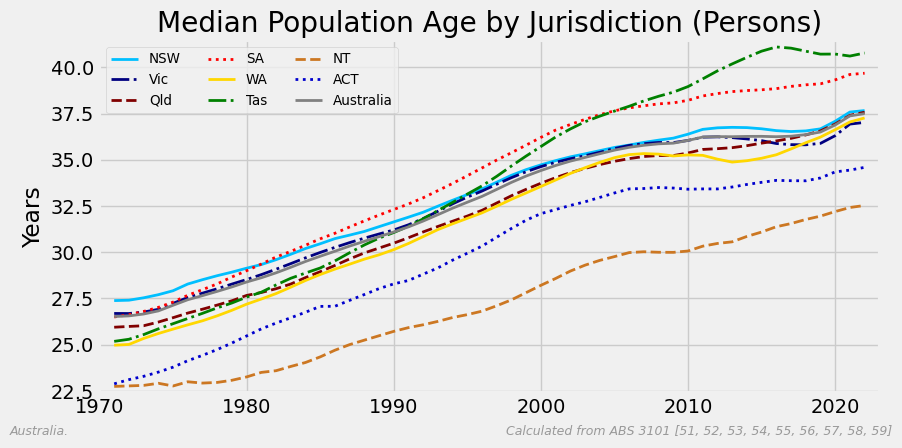

In [11]:
for group in groups:
    state_medians = {}

    # data capture
    for table in tables:
        state, df = get_age_data(table, group)
        state_medians[state] = calculate_medians(df)
    data = pd.DataFrame(state_medians)

    # plot 
    colors = [state_colors[x] for x in data.columns]
    line_plot(
        data,
        color=colors,
        **linestyle,
        title=f"Median Population Age by Jurisdiction ({group})",
        ylabel="Years",
        xlabel=None,
        legend={"loc": "best", "fontsize": "x-small", "ncols": 3},
        lfooter=f"Australia. ",
        rfooter=f"Calculated from {source} {[int(i) for i in tables]}",
        show=SHOW,
    )

#### Median Age by Gender

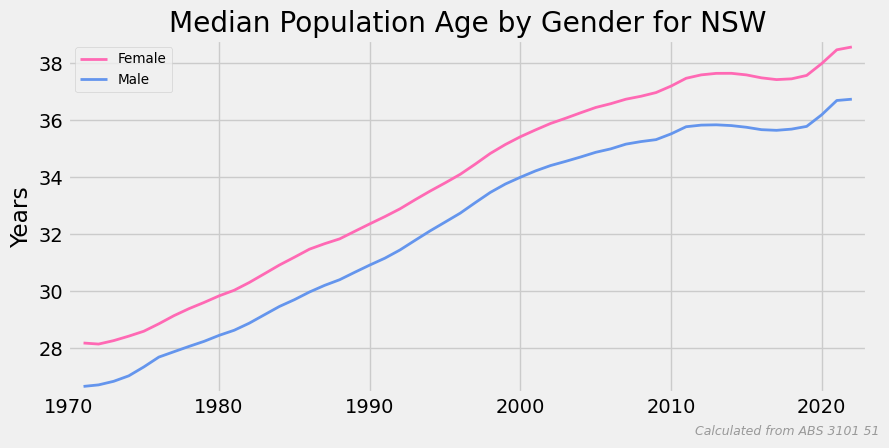

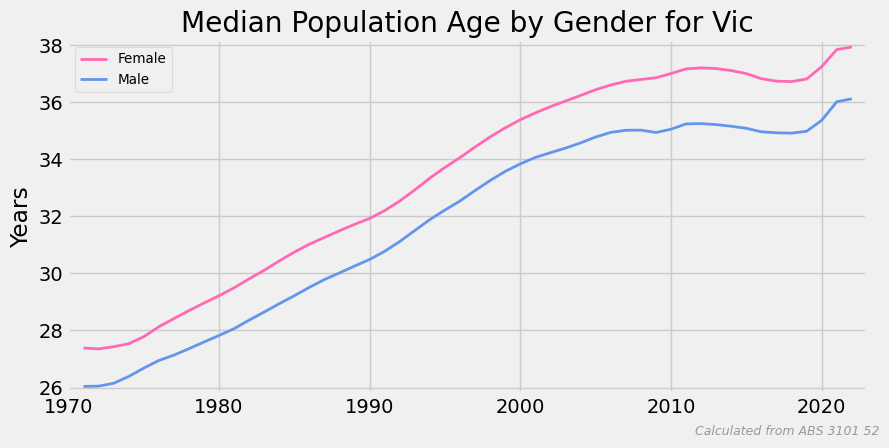

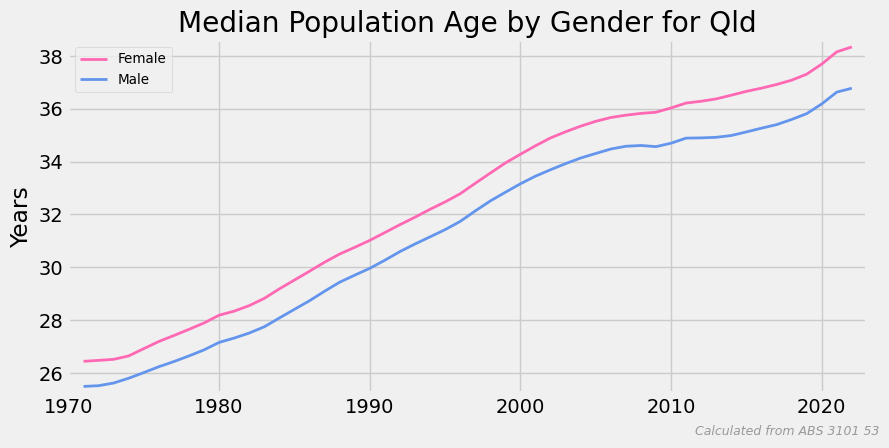

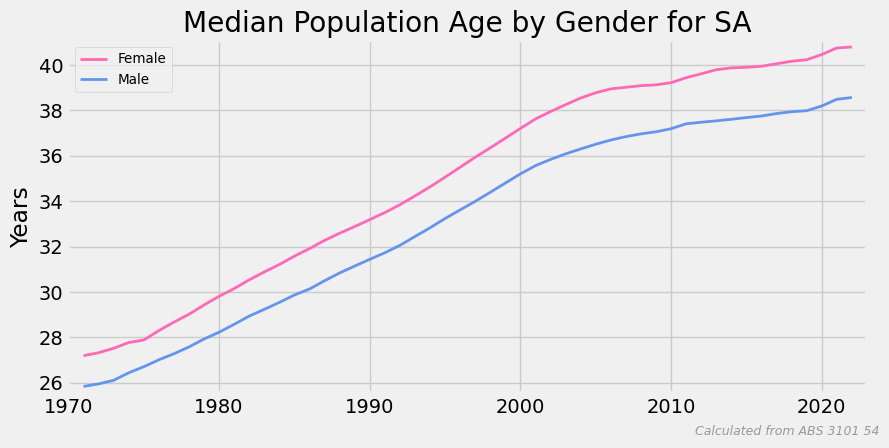

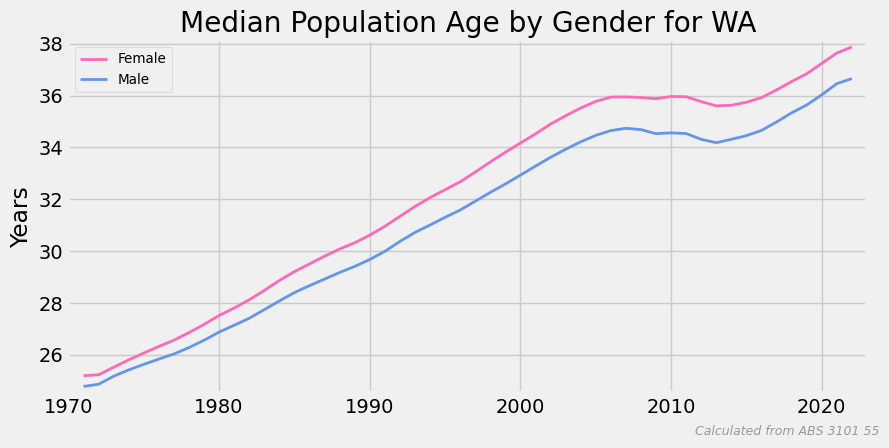

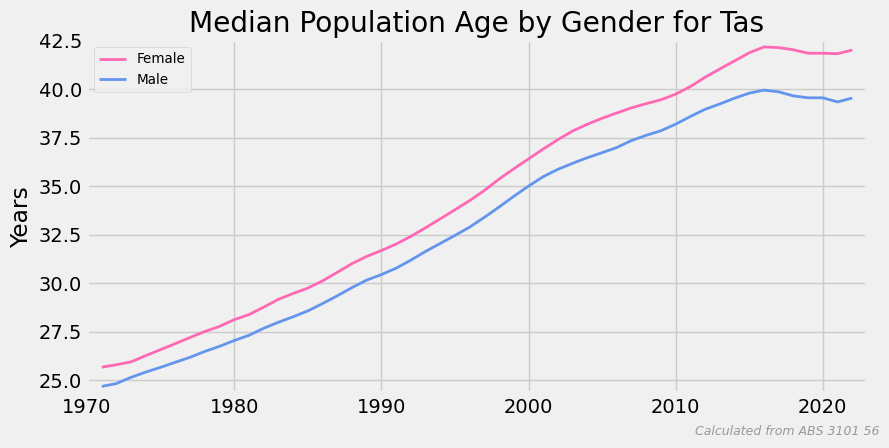

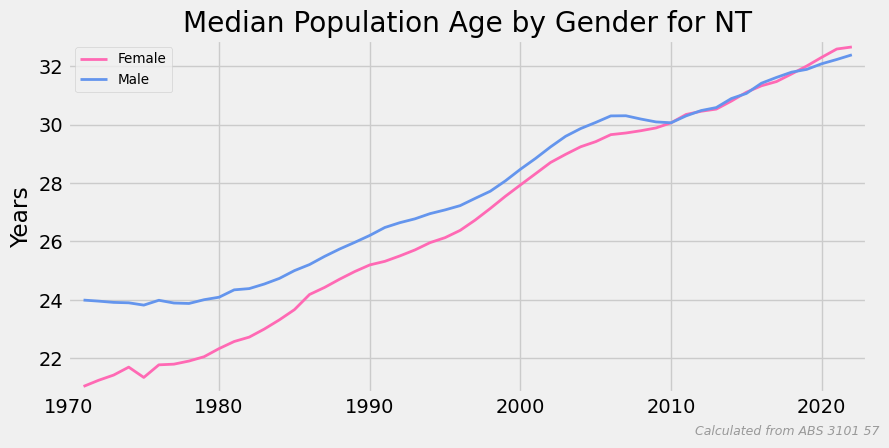

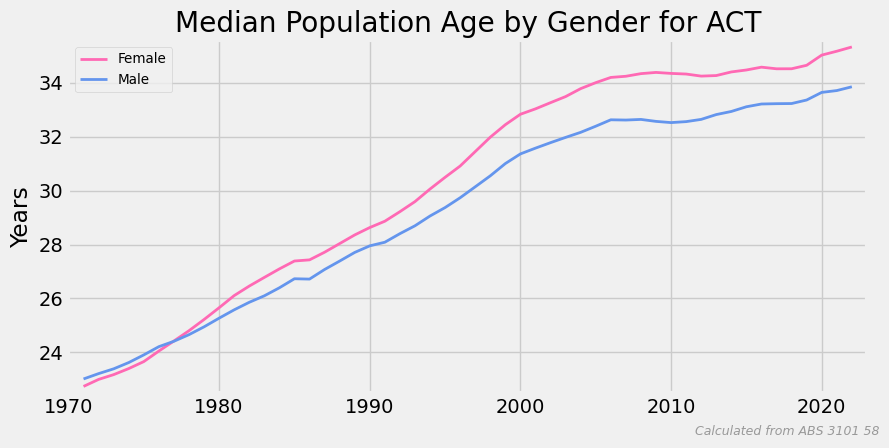

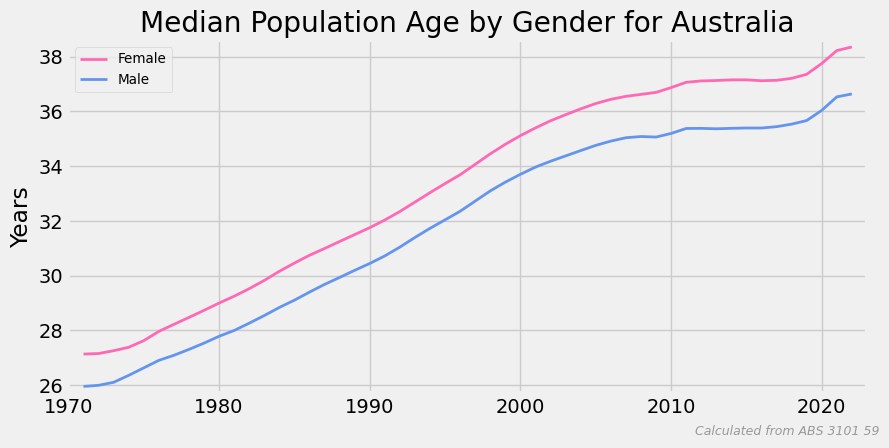

In [12]:
colors = (
    "hotpink",
    "cornflowerblue",
)

for table in tables:
    # data capture
    group_medians = {}
    for group in groups[0:2]:  # assumes "Persons" is last group
        state, data = get_age_data(table, group)
        group_medians[group] = calculate_medians(data)
    data = pd.DataFrame(group_medians)

    # plot
    line_plot(
        data,
        color=colors,
        title=f"Median Population Age by Gender for {state}",
        ylabel="Years",
        rfooter=f"Calculated from {source} {table}",
        show=SHOW,
    )

### National and State Populations

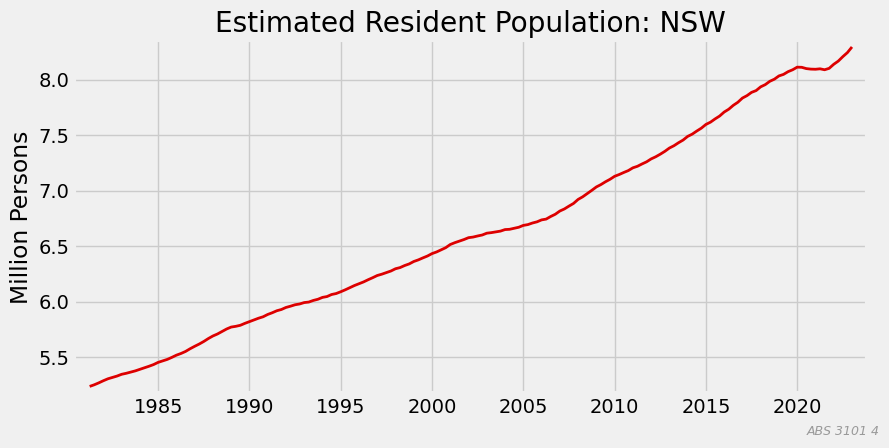

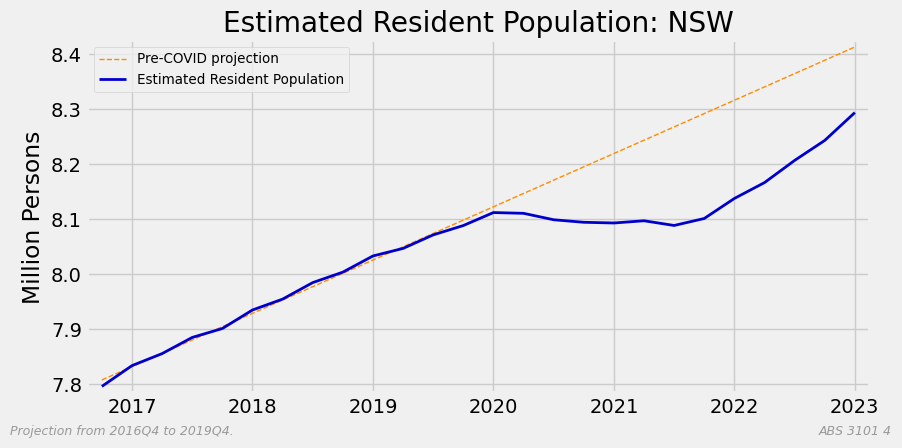

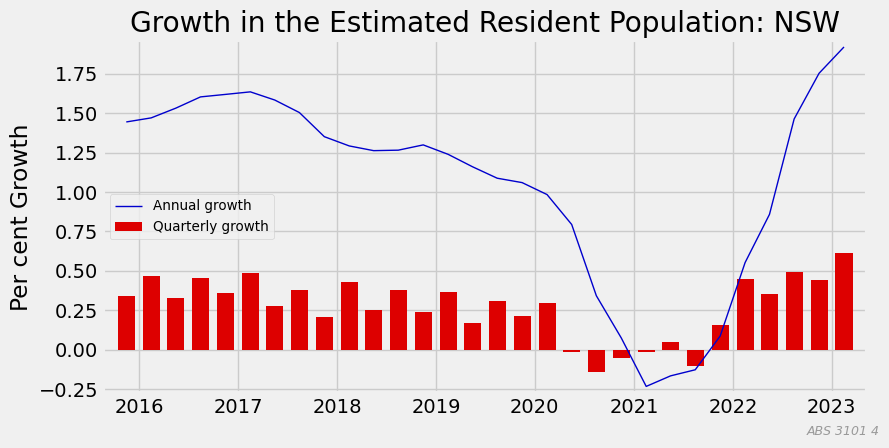

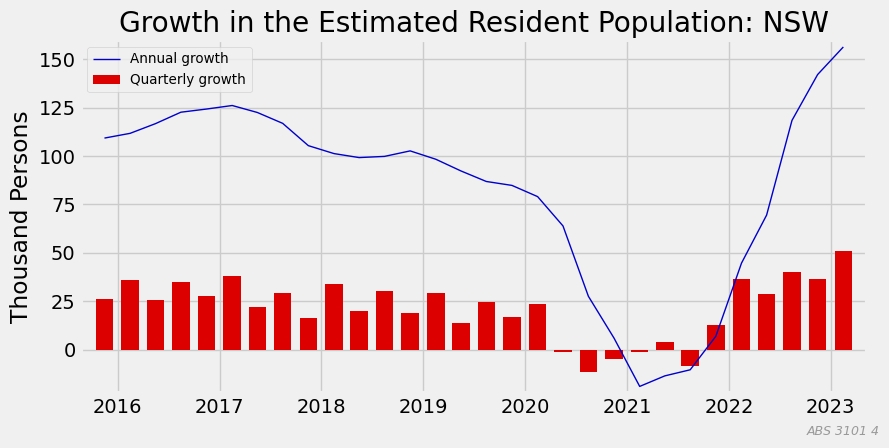

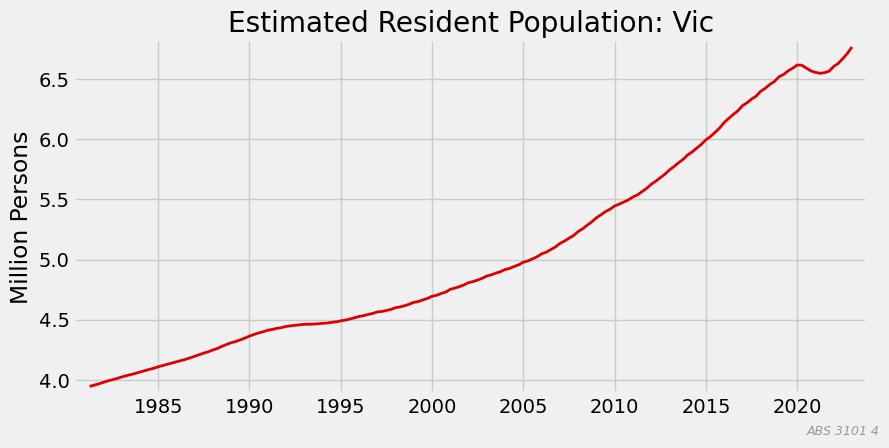

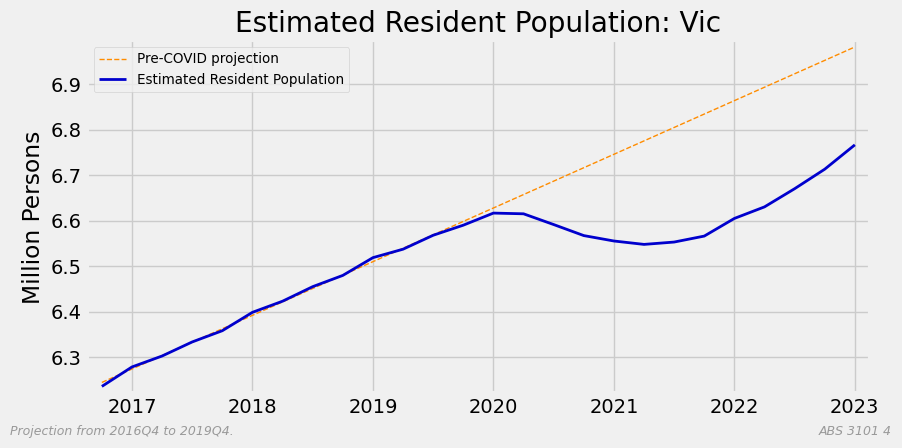

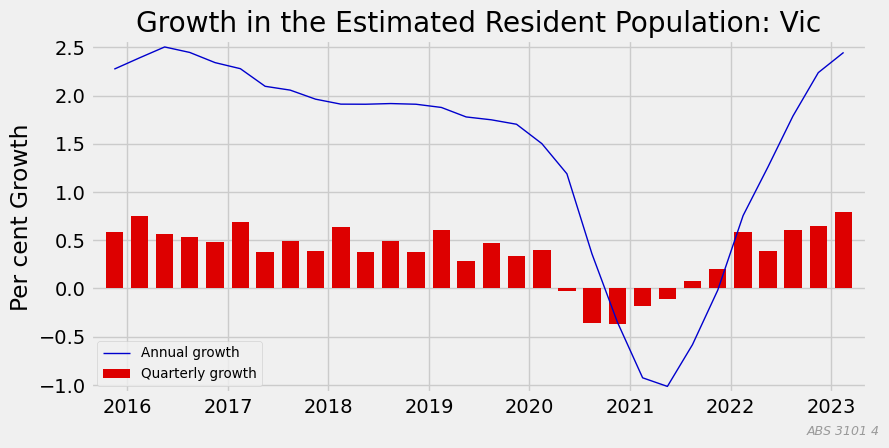

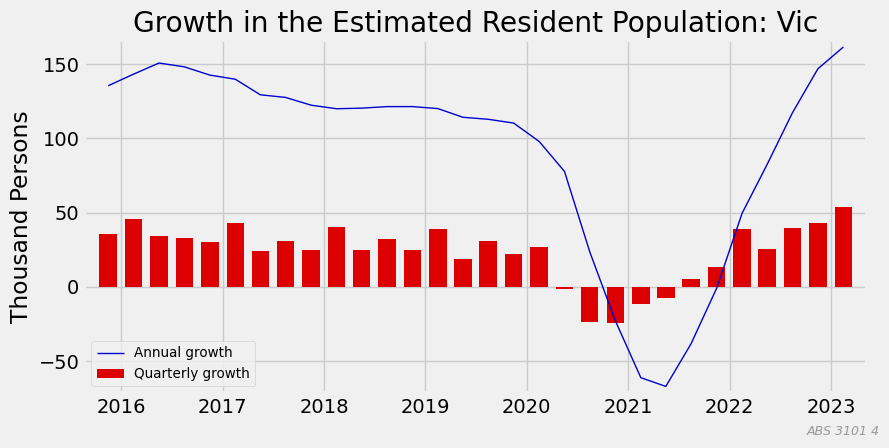

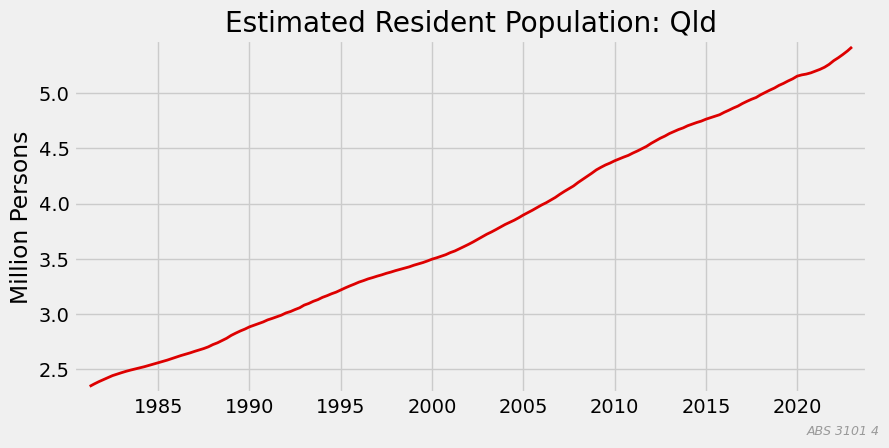

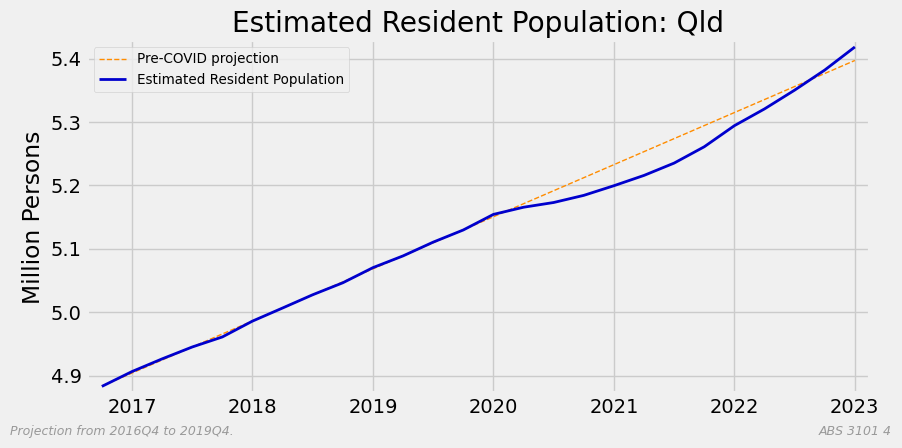

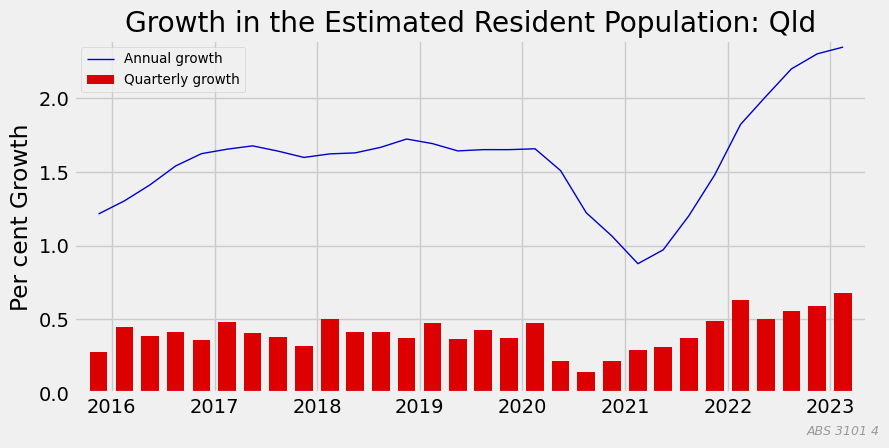

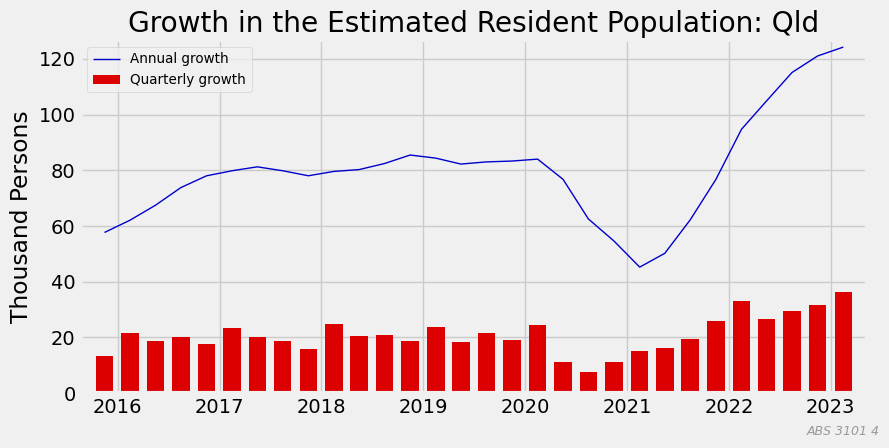

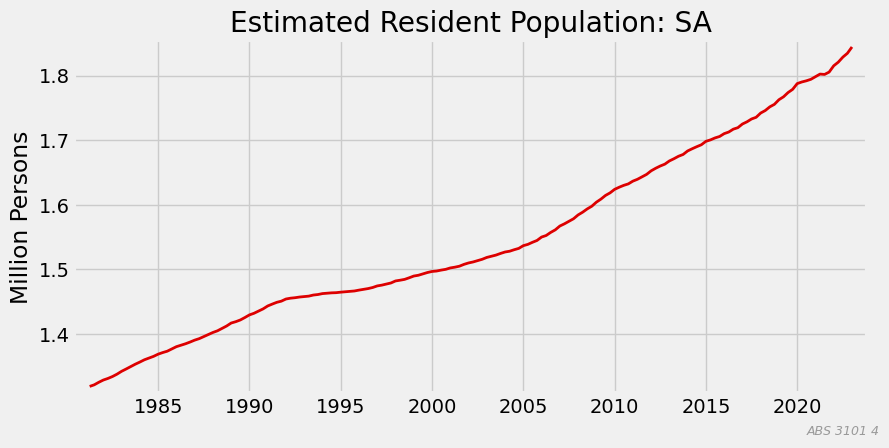

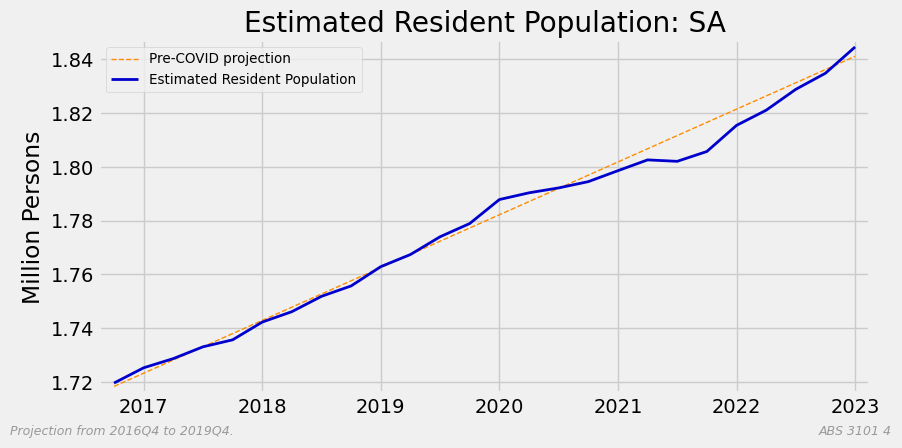

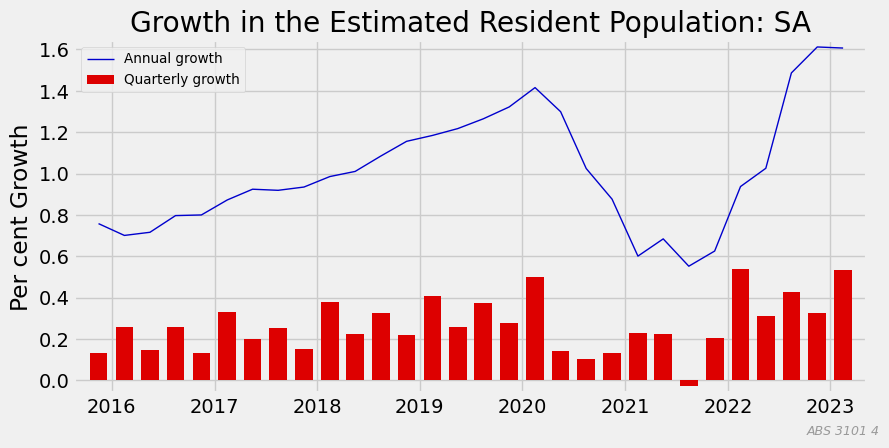

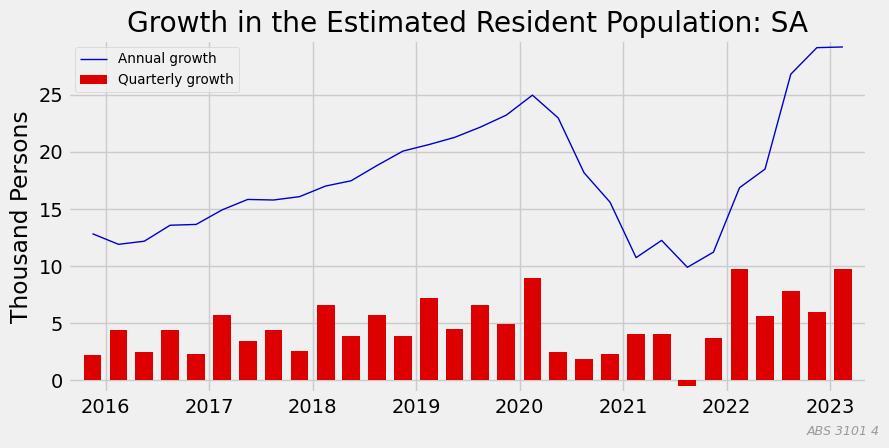

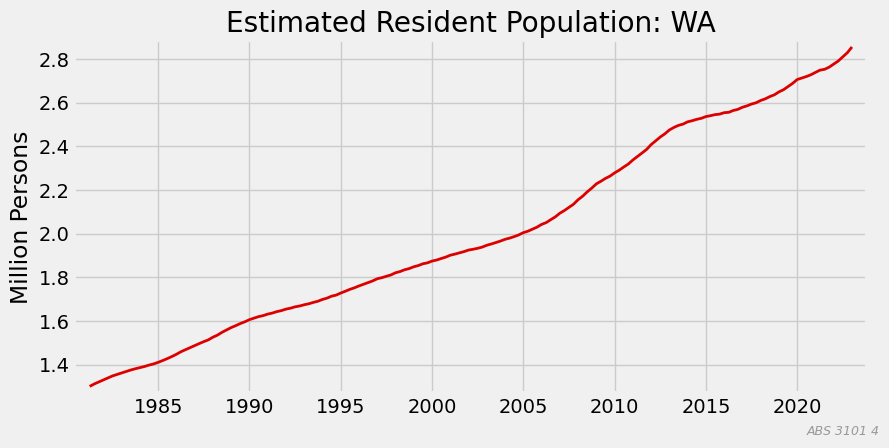

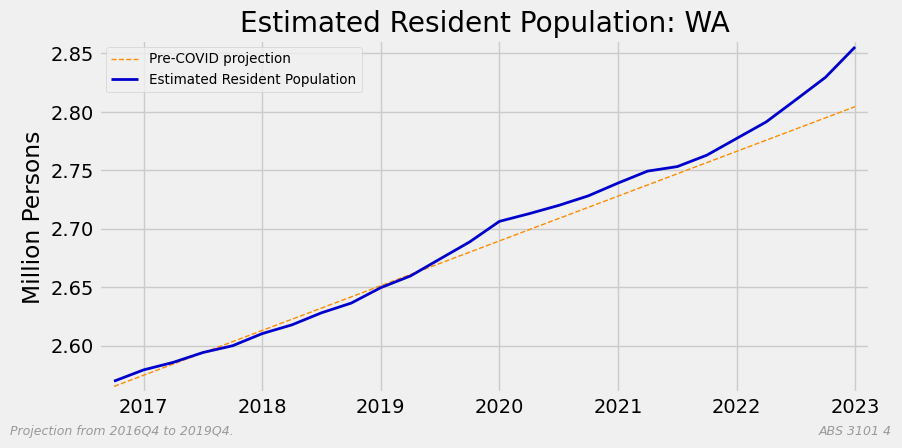

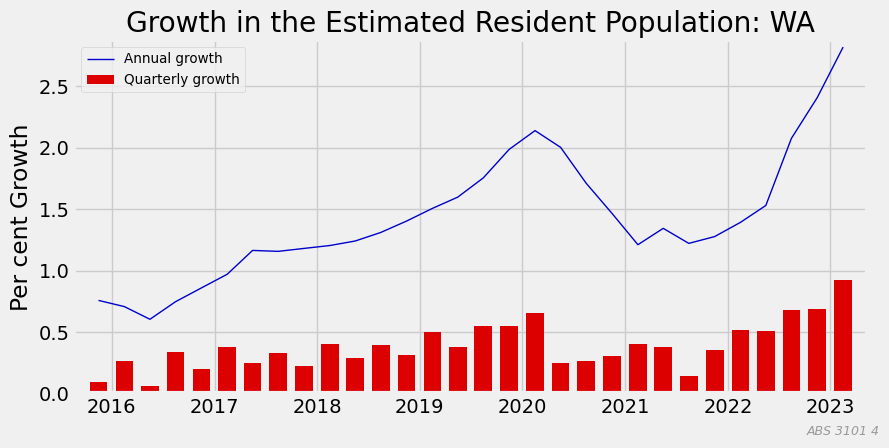

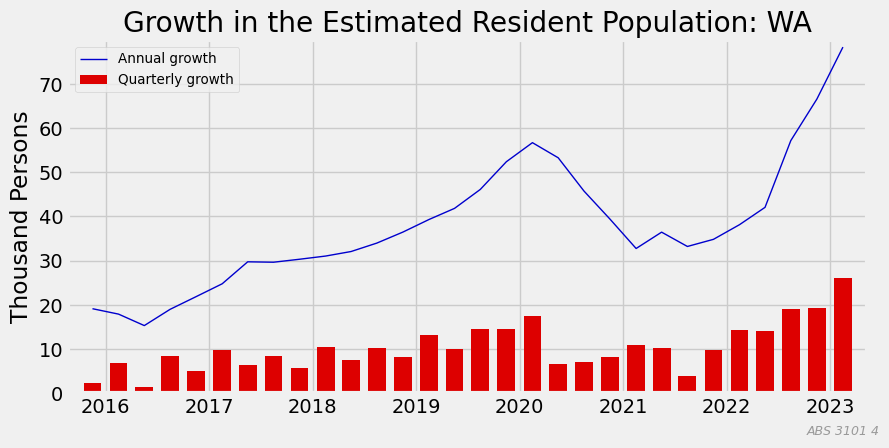

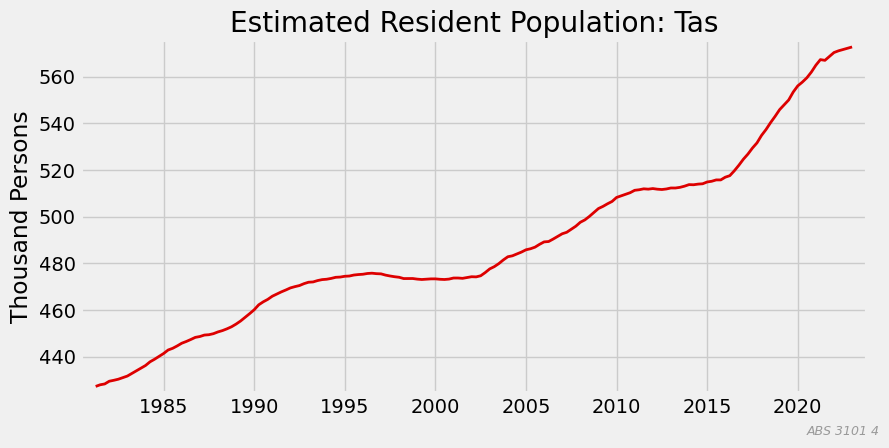

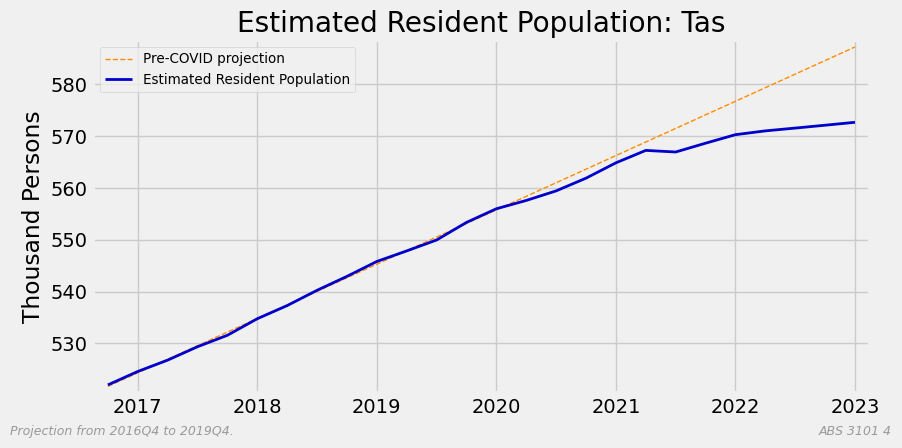

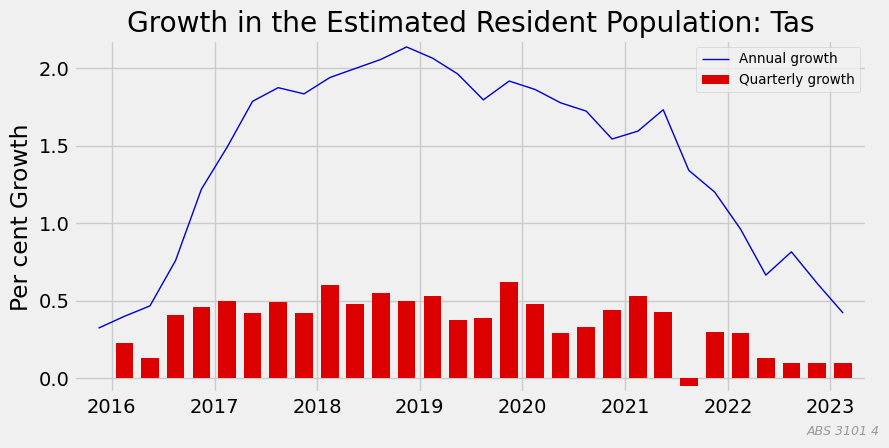

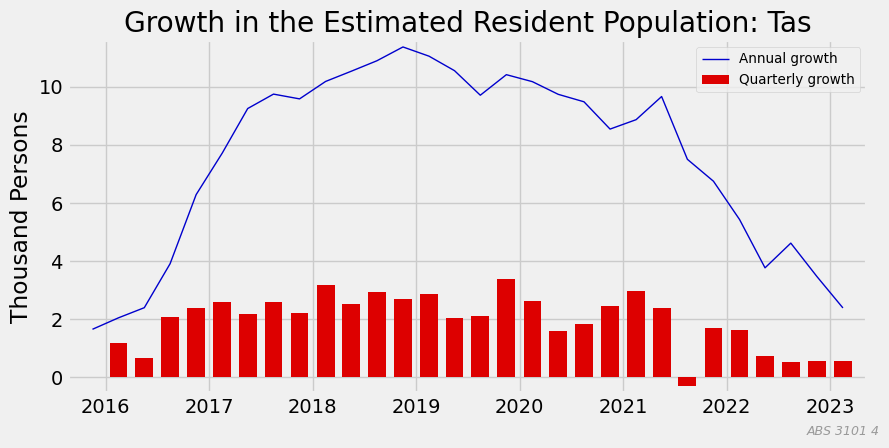

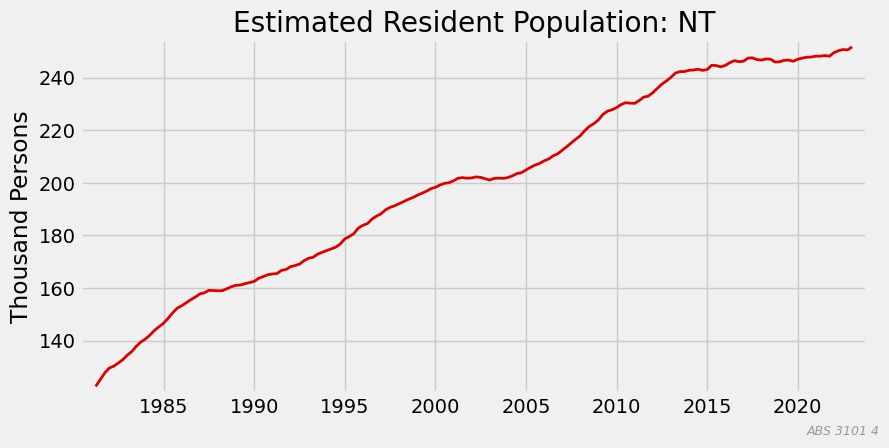

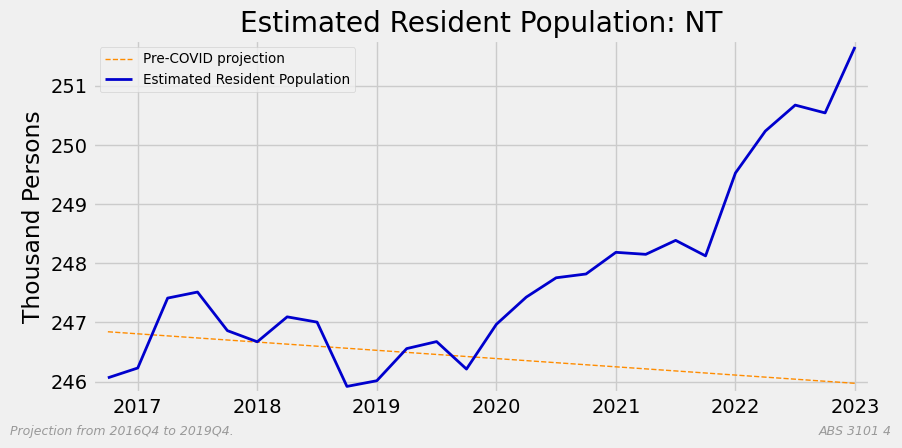

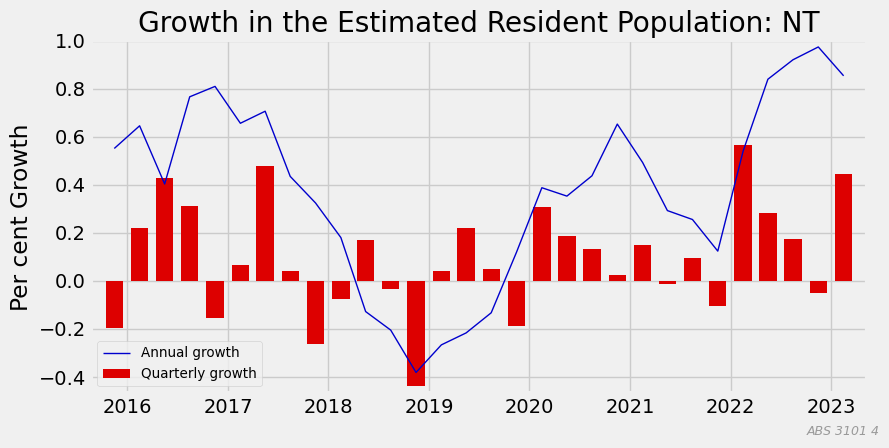

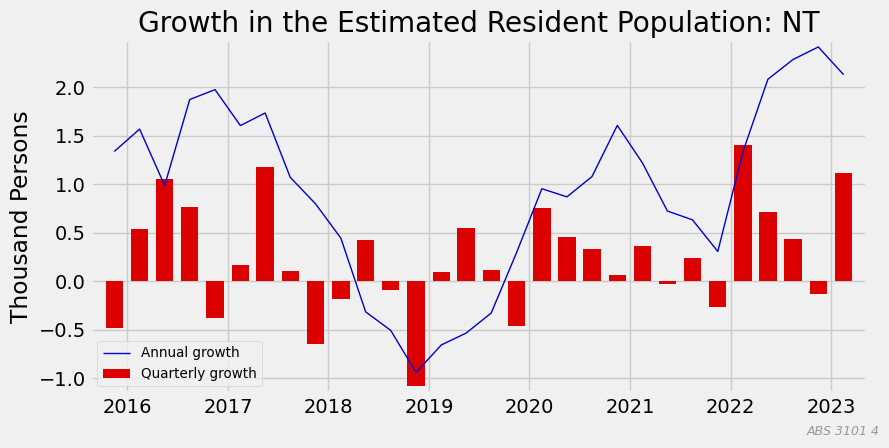

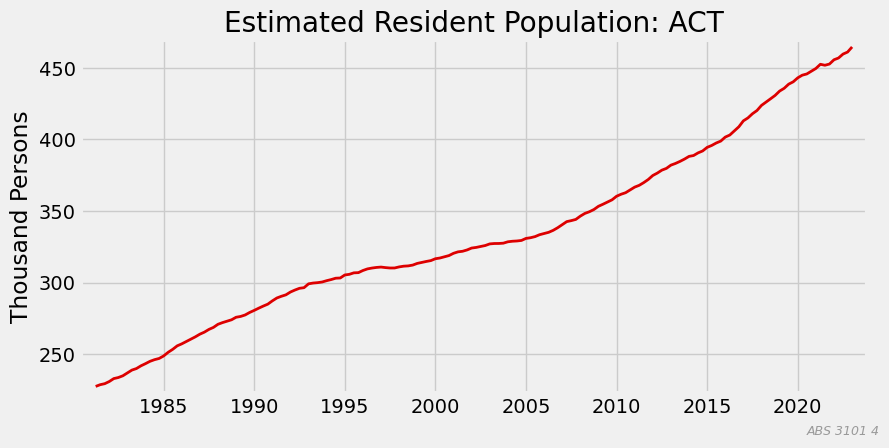

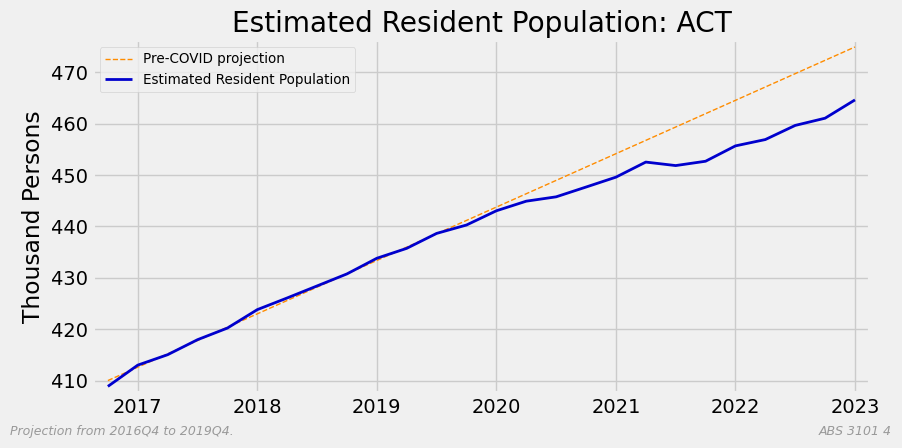

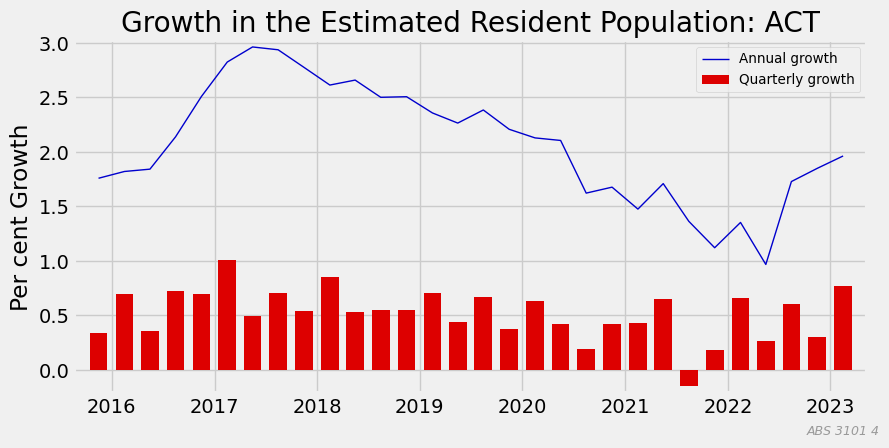

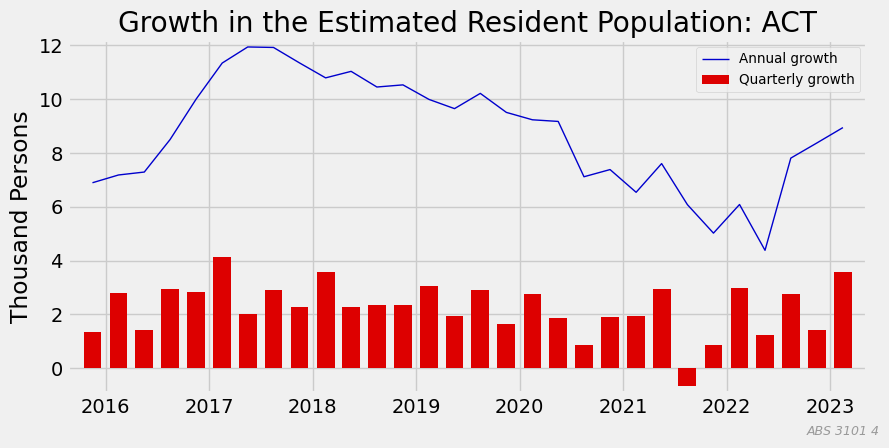

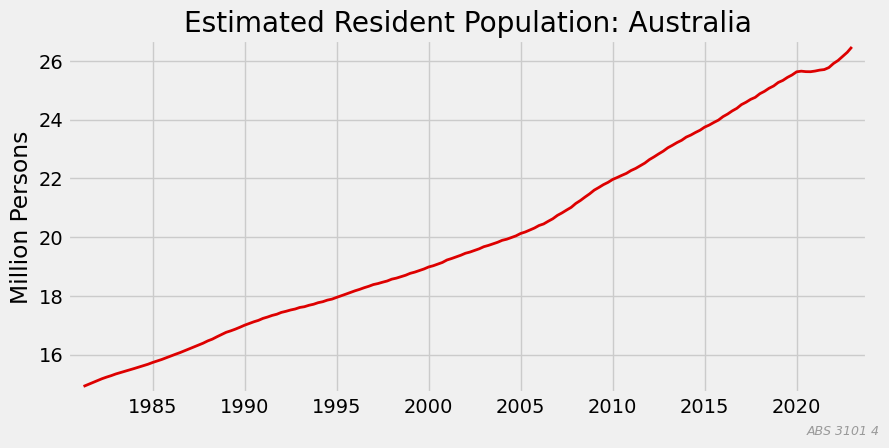

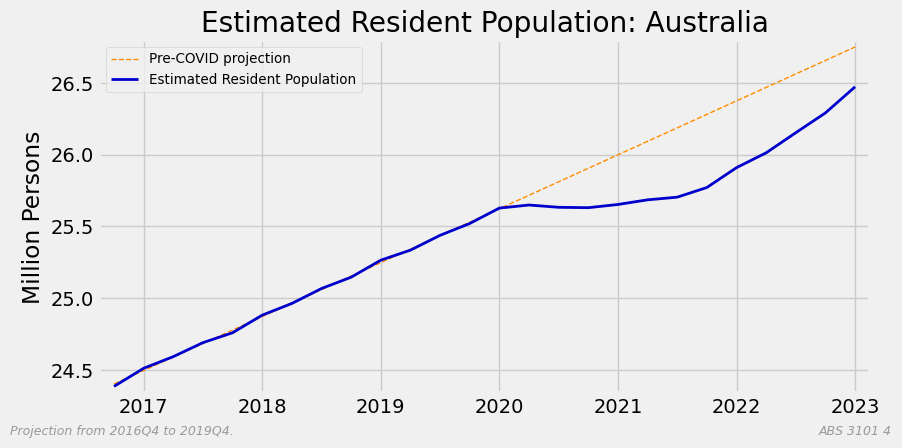

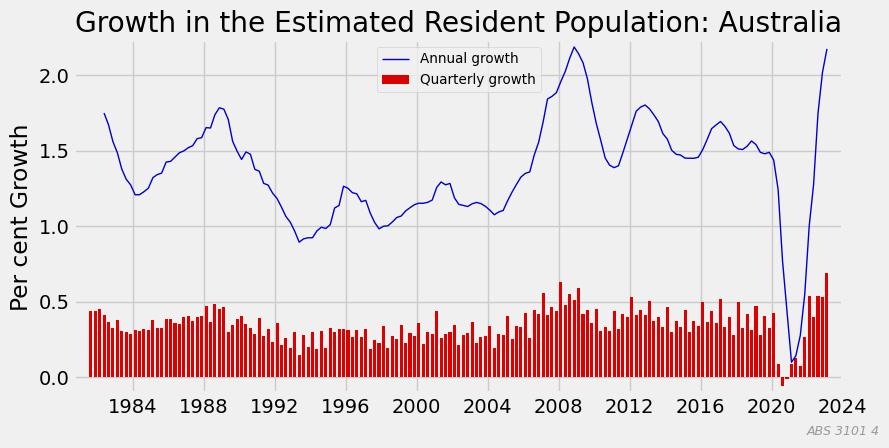

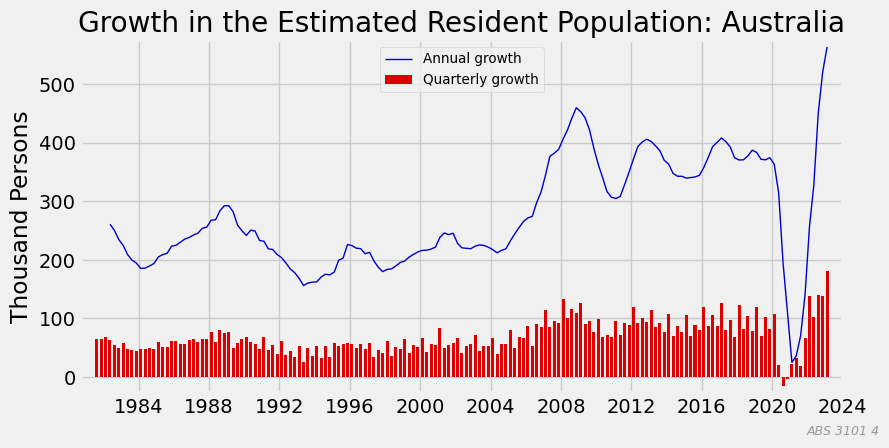

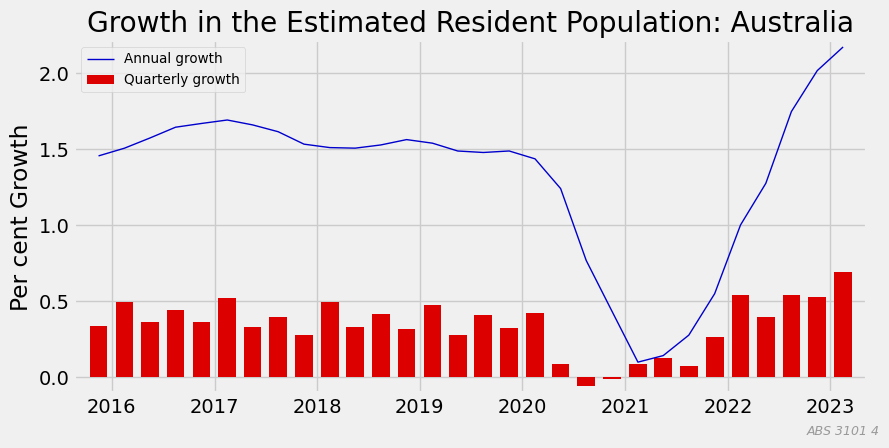

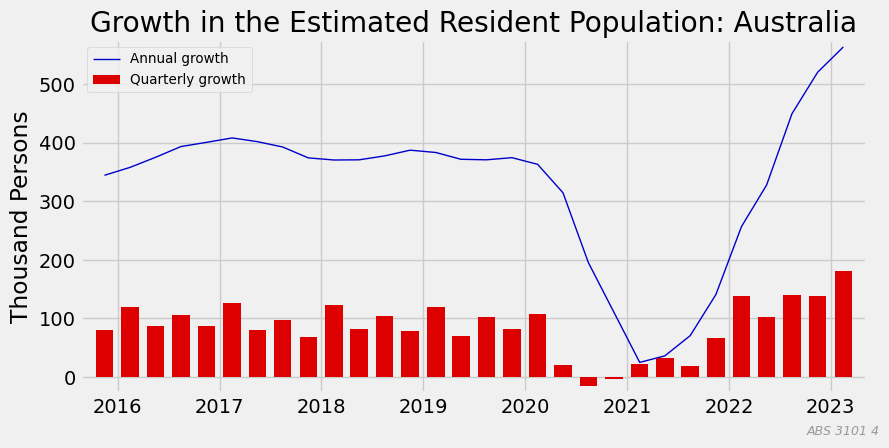

In [13]:
table = "4"
erp_df = erp_dict[table]
erp_phrase = "Estimated Resident Population ;  Persons ;"

states = (
    erp_meta.loc[
        (erp_meta[table_col] == table) & (erp_meta[did_col].str.contains(erp_phrase)),
        did_col,
    ]
    .str.replace(erp_phrase, "")
    .str.replace(" ;", "")
    .str.strip()
    .str.strip()
    .to_list()
)

for state in states:
    # get relevant data series
    selector = {
        table: table_col,
        erp_phrase: did_col,
        f";  {state} ;": did_col,  # Australia, South Australia, etc.
    }
    id, units = find_id(erp_meta, selector, verbose=False)
    series = erp_df[id]
    series.name = "Estimated Resident Population"
    units = "Number Persons" if units == "Persons" else units
    series, units = recalibrate(series, units)

    # plot complete series
    title = f"Estimated Resident Population: {abbreviate(state)}"
    line_plot(
        series,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        show=SHOW,
    )

    plot_covid_recovery(
        series,
        title=title,
        ylabel=units,
        tags="-covid",
        rfooter=f"{source} {table}",
        show=SHOW,
    )

    for start, tag in zip(plot_times, plot_tags):
        if state != "Australia" and start is None:
            continue

        growth_percent = calc_growth(series)
        plot_growth_finalise(
            *growth_percent,
            from_=start,
            tag=f"percent-{tag}",
            title=f"Growth in the {title}",
            rfooter=f"{source} {table}",
            show=SHOW,
        )

        growth_number = pd.DataFrame(
            [series.diff(4), series.diff(1)], index=["Annual", "Quarterly"]
        ).T
        growth_number, gunits = recalibrate(growth_number, units)
        plot_growth_finalise(
            growth_number["Annual"],
            growth_number["Quarterly"],
            from_=start,
            ylabel=gunits,
            title=f"Growth in the {title}",
            tag=f"numeric-{tag}",
            rfooter=f"{source} {table}",
            show=SHOW,
        )

## Finished

In [14]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Oct 01 2023 11:18:18

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.0

sys       : 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:35:23) [Clang 15.0.7 ]
matplotlib: 3.8.0
pandas    : 2.1.1

Watermark: 2.4.3



In [15]:
print("Finished")

Finished
